# Score Estimations, Langevin Generative models and NCSN

By Addisu Amare

$\textbf{Date}:$ 08.11.24

In [ ]:
import torch
from torch.distributions import MultivariateNormal, Normal
import numpy as np
import tqdm
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Teachers - Ground-Truth data

The $\textbf{Teacher}$ is the class of the density distribution, which we want to approximate by neural-network-based approaches. This class has the following methods:

- sample(sampling from the density distribution)
- log_prob(calculation of the logarithm of the distribution)

Undoubtedly, in order to calculate the ground-truth logarithm of the distribution we define the distribution by such way to analytically compute the gradient of the logartihm. Thus, one can take the Teacher, which is the ground-truth distribution thrrough the notebook, as follows:

$$\mathbb{P} = \frac{1}{5}\mathcal{N}((-5,-5),I) + \frac{4}{5}\mathcal{N}((5,5),I)$$

In [ ]:
class GMMDist(object):
    def __init__(self, dim):
        self.mix_probs = torch.tensor([0.8, 0.2])
        self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        self.sigma = 1
        self.std = torch.stack([torch.ones(dim) * self.sigma for i in range(len(self.mix_probs))], dim=0)

    def sample(self, n):
        """
        n - int
        """
        n = torch.Size([n])[0]
        mix_idx = torch.multinomial(self.mix_probs, n, replacement=True)
        means = self.means[mix_idx]
        stds = self.std[mix_idx]
        return torch.randn_like(means) * stds + means

    def log_prob(self, samples):
        """
        samples - torch.Size([B,N])
        """
        logps = []
        for i in range(len(self.mix_probs)):
            logps.append((-((samples - self.means[i]) ** 2).sum(dim=-1) / (2 * self.sigma ** 2) - 0.5 * np.log(
                2 * np.pi * self.sigma ** 2)) + self.mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp

In [ ]:
def plot_teachers(teacher, num_samples):
    """
    num_samples - int

    """
    plt.figure(figsize=(4,4),dpi=150 )
    samples = teacher.sample(num_samples)
    plt.scatter(samples[:,0],samples[:,1],s=10,edgecolor='black')
    plt.grid()


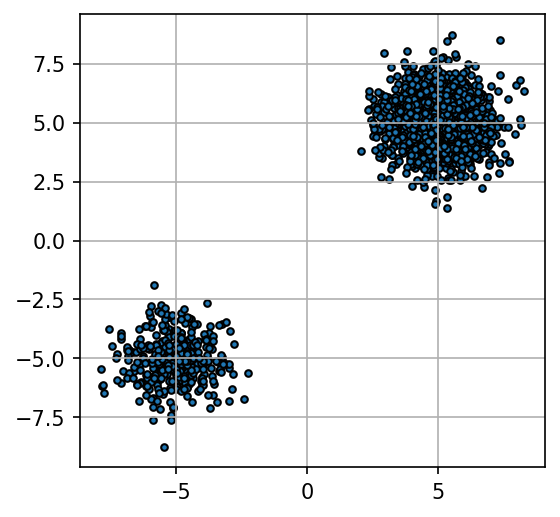

In [ ]:
DIM = 2
NUM_SAMPLES_PLOT = 2000
teacher =  GMMDist(DIM)
plot_teachers(teacher,  NUM_SAMPLES_PLOT)

In [ ]:
def data_score(x):
    x = x.detach()
    x.requires_grad_(True)
    y = teacher.log_prob(x).sum()
    return torch.autograd.grad(y, x)[0]

In [ ]:
def toy_net(hiddens):
    model = []
    for inp,outp in zip(hiddens[:-1],hiddens[1:]):
        model.append(torch.nn.Linear(inp,outp,bias=True))
        model.append(torch.nn.ReLU())
    model.pop()
    return torch.nn.Sequential(*model)

## 1. Score-based genereative modeling

In [ ]:
def plot_loss_quiever(model,teacher, label = None):

    grid_size = 20
    left_bound=-3
    right_bound=3
    mesh = []
    x = np.linspace(left_bound, right_bound, grid_size)
    y = np.linspace(left_bound, right_bound, grid_size)
    for i in x:
        for j in y:
            mesh.append(np.asarray([i, j]))

    mesh = np.stack(mesh, axis=0)
    mesh = torch.from_numpy(mesh).float()

    if label == "energy":
        mesh.requires_grad = True
        scores = model(mesh)
        scores = torch.autograd.grad(scores.sum(),mesh,create_graph=True)[0]
    else:
        scores = model(mesh.detach())

    mesh = mesh.detach().numpy()
    scores = scores.detach().numpy()
    fig,ax = plt.subplots(1,2,figsize=(16,8),sharex=True,sharey=True)

    ax[0].grid(False)
    ax[0].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
    ax[0].set_title('Estimated scores', fontsize=16)
    ax[0].axis('square')

    scores = data_score(torch.from_numpy(mesh))
    scores = scores.detach().numpy()

    ax[1].grid(False)
    ax[1].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
    ax[1].set_title('Data scores', fontsize=16)
    ax[1].axis('square')

### 1.1 Fischer divergence

$\textbf{Notation}:$

- $x \in \mathbb{R}^{D}, \quad x \sim \mathbb{P}(\cdot)$
- The model for approximation of $\mathbb{P}$ is $\mathbb{\hat{P}}(x, \theta) = \frac{1}{Z(\theta)}\mathbb{Q}(x,\theta)$, unnormalized density
- Desires: One would like to find out such parameters to apprroximate the ground-truth distribution better.
- $\mathbb{\hat{P}}(x, \theta)$ is reffered to as Energy-based models.

Considering the gradient of the approximation:

$$ \nabla_{x} \log \mathbb{\hat{P}}(x,\theta) = \nabla_{x} \log \mathbb{Q}(x,\theta) - \nabla_{x} \log Z(\theta) = \nabla_{x} \log \mathbb{Q}(x,\theta) - 0 $$

We see, that in order to estimate the gradient of logarithm of approximate distribution, we need in the gradient of unnormalized density $\mathbb{Q}(\cdot, \theta)$. Such gradient of unnormalized density is called $\textbf{Score function}$ and is denoted as $\psi(x,\theta)$.

$\textbf{The main goal of notebook}:$

We would like to estimate the gradient of logarithm of the ground-truth density $\mathbb{P}$ by the score function.

Undoubtedly, when we have the access to the ground-truth grradient of logarithm of density, we can consider easy regression problem between $\mathbb{Q}$ and $\mathbb{P}$. This easy regression prroblem is reffered to as $\textbf{Fischer divergence}$.

Let $p(x)$ and $q(x)$ are ground-truth distribution of data and unnormalized approximate distribution. The both functions are scalar functios.
$$ F(q||p)=\frac{1}{2}\int || - \nabla_{x}\log q(x) + \nabla_{x} \log p(x) ||_{2}^{2}dp(x)  $$

![ChessUrl](https://media3.giphy.com/media/JRPftUYuIRw3axuh5y/giphy.gif "chess")


$\textbf{Code}$ for the Fischer divergence.

In [ ]:
def fischer_divergence(energy_net, data, teacher):

    """
    energy_net - torch.nn.Module
    teacher    - object
    data.      - torch.Size([B,N])
    """

    data.requires_grad = True
    logq = -energy_net(data) # torch.Size([B,1])
    logp = teacher.log_prob(data)# torch.Size([B,1])
    q_score = torch.autograd.grad(logq.sum(), data,
                                   create_graph=True,retain_graph=True)[0]
    p_score = torch.autograd.grad(logp.sum(), data,
                                 create_graph=True,retain_graph=True)[0]
    return 0.5*torch.mean(torch.norm((q_score + p_score)**2,dim=-1))

In [ ]:
HIDDENS = [DIM,64,128,256,128,64,1]
model = toy_net(HIDDENS)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
batch_size=2048
iterations=5000
losses = []
for _ in tqdm.tqdm(range(iterations)):
    opt.zero_grad()
    samples = teacher.sample(batch_size)
    loss = fischer_divergence(model,samples,teacher)
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|██████████| 5000/5000 [03:37<00:00, 22.95it/s]


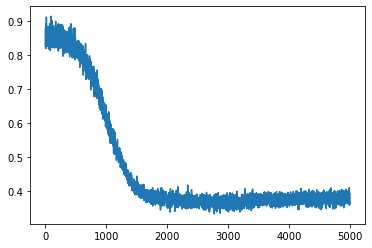

In [ ]:
plt.plot(losses);

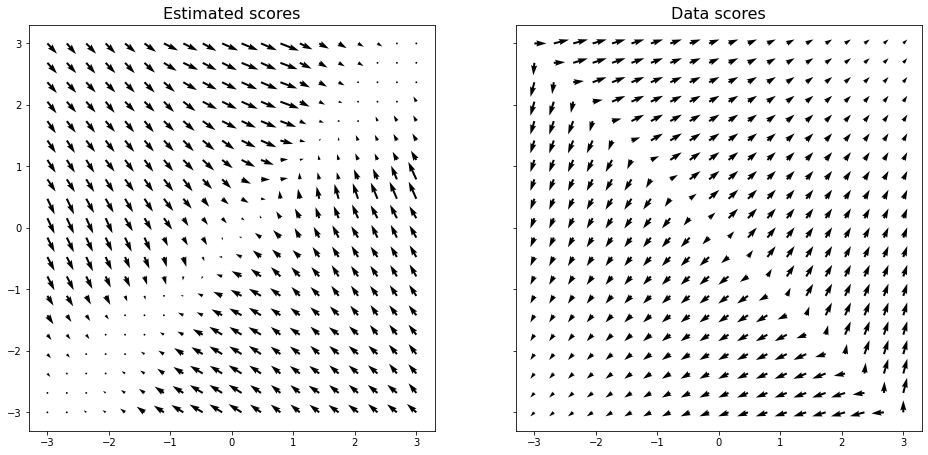

In [ ]:
plot_loss_quiever(model, teacher, label='energy')

### 1.2 Score Matching and Estimation.

$\textbf{Importantly}:$

When we talk $\textbf{Score Estimation}$, it means, that we solve the regression problem between $\psi(x,\theta)$, where $\psi(x,\theta)$ is a neural network. When we talk $\textbf{Score Matching}$, it means, that we solve the regression problem between $\psi(x,\theta)$, where $\psi(x,\theta)$ is $\nabla_{x} \log q(x,\theta)$ and $q(x,\theta)$ is a neural-network.


![alt text](rowan-atkinson.jpeg "Title")

$\textbf{Theorem 1}:$
Let $\psi(x,\theta): \mathbb{R}^{D} \to \mathbb{R}^{D}$ is a regular differetiable function. Having defined
the score function as follows :

$$\psi_{i}(x,\theta) = \frac{\partial \log q(x,\theta)}{\partial x_{i}}, \quad \frac{\partial \psi(x,\theta)}{\partial x_{i}} = \frac{\partial^{2} \log q(x,\theta)}{\partial x_{i}^{2}} $$

Then:

$$\mathcal{J}(\theta) = \int_{\mathbb{R}^{D}} \sum_{i=1}^{D} \{ \frac{\partial \psi(x,\theta)}{\partial x_{i}}+ \frac{1}{2}\psi(x,\theta)^{2}\}d\mathbb{P}(x) + Const.$$

$\textbf{proof}:$ See the  Seminar

In [ ]:
def score_matching(energy_net, data):
    """
    energy_net - torch.nn.Module
    data       - torch.Size([B,N])
    """
    data.requires_grad = True
    logq = -energy_net(data) # torch.Size([B,1])
    score = torch.autograd.grad(logq.sum(), data,
                                create_graph=True, retain_graph=True)[0]# torch.Size([B,N])

    loss1 = 0.5*torch.norm(score,dim=-1)**2 # torch.Size([B])

    grad_score = torch.autograd.grad(score.sum(dim=-1).sum() , data,
                                     create_graph=True, retain_graph=True)[0] #torch.Size([B,N])

    loss2 = grad_score.sum(dim=-1)#torch.Size([B])

    return torch.mean(loss1 + loss2 ,dim = 0)

In [ ]:
def score_estimation(score_net, data):
    """
    energy_net - torch.nn.Module
    data       - torch.Size([B,N])
    """
    data.requires_grad = True
    score = score_net(data)#torch.Size([B,N])
    loss1 =  0.5*torch.norm(score,dim=-1)**2 # torch.Size([B])
    grad_score = torch.autograd.grad(score.sum(),data,
                                    create_graph=True,retain_graph=True)[0]
    loss2 = grad_score.sum(dim=-1)# torch.Size([B])
    return torch.mean(loss1 + loss2 ,dim = 0)

In [ ]:
HIDDENS = [DIM,64,128,256,128,64,2]
model = toy_net(HIDDENS)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
batch_size=2048
iterations=5000
losses = []
for _ in tqdm.tqdm(range(iterations)):
    opt.zero_grad()
    samples = teacher.sample(batch_size)
    loss =  score_estimation(model,samples)
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|██████████| 5000/5000 [03:28<00:00, 24.04it/s]


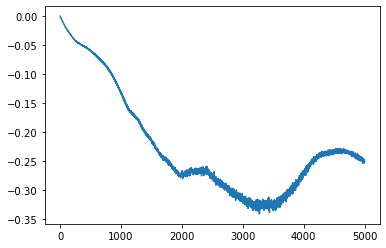

In [ ]:
plt.plot(losses);

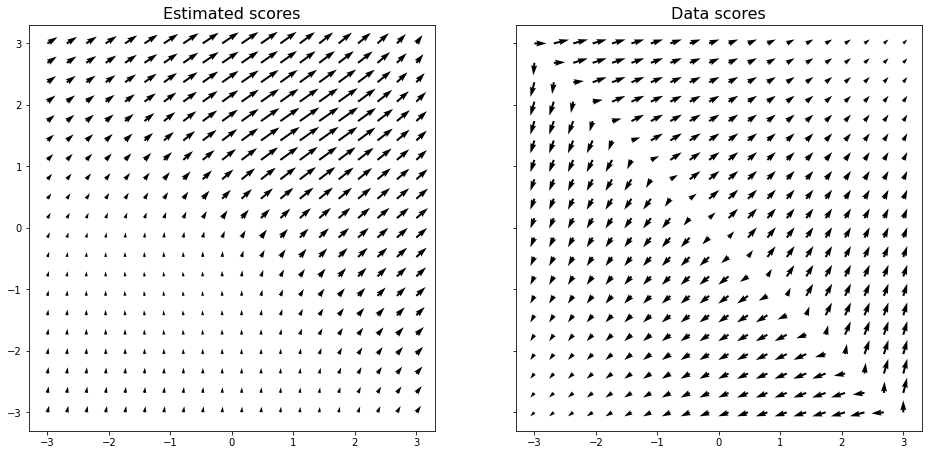

In [ ]:
plot_loss_quiever(model,teacher)

### 1.3 Denoising Score matching and estimation

Let's consider $\mathbb{P}_{\sigma}$ is as a perturbed data distribution of $\mathbb{P}_{\sigma}$. First of all, we pick out the noise scale $\sigma$ manually.

- $\mathbb{q}_{\sigma}(\tilde{x}|x) = \mathcal{N}(\tilde{x}|x,\sigma^{2}I)$ - conditional perturbed distribution.
- $\mathbb{P}_{\sigma}(\tilde{x},x) =\mathbb{q}_{\sigma}(\tilde{x}|x)\mathbb{P}(x)$ - joint distribution.
- $\mathbb{P}_{\sigma}^{m}(\tilde{x}) = \int \mathbb{P}_{\sigma}(\tilde{x},x) dx$ - marginal distribution.

$\textbf{Theorem 2:}$ Let $\mathbb{P}(x)$ is the gound-truth distribution, while $\psi(x,\theta): \mathbb{R}^{D} \to \mathbb{R}^{D}$ is learnable scorre function and tries to approximate the gradient of logarothm of $\mathbb{P}$. Then:
$$\mathbb{E}_{\mathbb{P}(x)} \{ \frac{1}{2}||\psi(x,\theta) - \frac{\partial}{\partial x} \log \mathbb{P}(x) ||_{2}^{2}\} \sim \mathbb{E}_{\mathbb{P}_{\sigma}(x,\tilde{x})}\{\frac{1}{2}||\psi(\tilde{x},\theta) - \frac{\partial}{\partial \tilde{x}} \log \mathbb{P}_{\sigma}(\tilde{x}|x) ||_{2}^{2}\}$$

$\textbf{Proof}:$ On seminar

In [ ]:
def denoising_score_matching( score_net, samples, sigma):

    """
    score_net - torch.nn.module
    samples   - torch.Size([B,N])
    sigma     - int
    """

    samples.requires_grad = True
    vector = torch.randn_like(samples, device = samples.device)*sigma
    perturbed_samples = samples + vector
    logp = - score_net(perturbed_samples)
    dlogp = sigma**2*torch.autograd.grad(logp.sum(), perturbed_samples,
                                         create_graph=True, retain_graph=True)[0]
    kernel = vector
    return 0.5*torch.mean(torch.norm(dlogp + kernel, dim=-1)**2)

In [ ]:
def denoising_score_estimation( score_net, samples, sigma):

    """
    score_net - torch.nn.module
    samples   - torch.Size([B,N])
    sigma     - int
    """

    perturbed_samples = samples + torch.randn_like(samples, device = samples.device)*sigma
    score = score_net(perturbed_samples)
    dlogq =  1/sigma**2*(samples - perturbed_samples )
    return 0.5*torch.mean(torch.norm((score - dlogq)**2,dim=-1))

In [ ]:
model = toy_net(HIDDENS)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
batch_size=2048
iterations=5000
losses = []
for _ in tqdm.tqdm(range(iterations)):
    opt.zero_grad()
    samples = teacher.sample(batch_size)
    loss =  denoising_score_estimation(model,samples,0.01)
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|██████████| 5000/5000 [00:30<00:00, 166.51it/s]


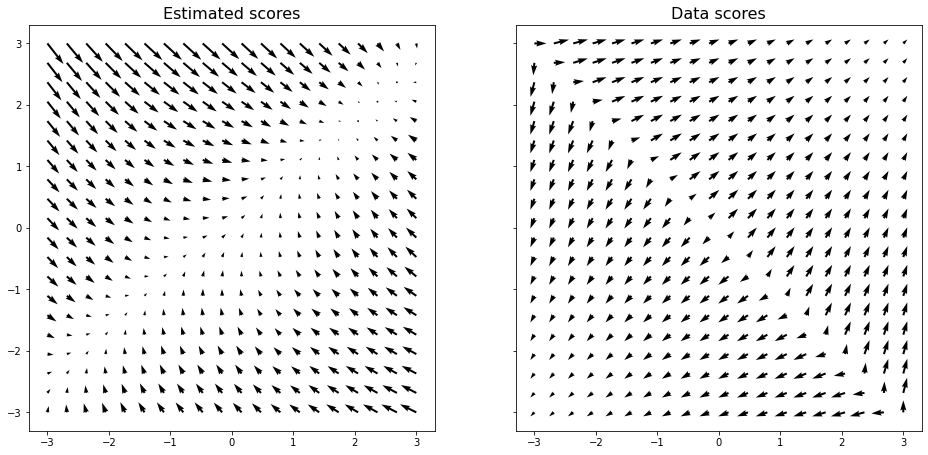

In [ ]:
plot_loss_quiever(model,teacher)

### 1.4 Sliced Score matching and estimation

To understand Sliced Score Estimation, we recall $S_{d}(x)$ and $\psi(x,\theta)$, where the firrst is the ground-truth score function. If we solve any regression problem between $S_{d}(x)$ and $\psi(x,\theta)$, then we have the problem between two high-dimensional vectors. One would like to reduce the dimensionality of the problem. The random projection is one of the possible solutions.

$$ F(\mathbb{Q},\mathbb{P}) = \frac{1}{2}\int_{\mathbb{R}^{D}}||\psi(x,\theta) - S_{d}(x) ||_{2}^{2} $$

Then, we rewrite the aforementioned expression via projections on random Gaussian vectors:

$$ \mathcal{L}(\theta) = \frac{1}{2}\mathbb{E}_{p_{v}}\mathbb{E}_{\mathbb{P}(x)}||v^{T}\psi(x,\theta) - v^{T}S_{d}(x)||_{2}^{2},$$

where $p_{v}(v) = \mathcal{N}(v|0,I)$, and we imply, that $\mathbb{E}_{p_{v}}||v||^{2}_{2} < \infty$

$\textbf{Theorem 3}$: Let $\psi(x,\theta)$ is a score function, $S_{d}(x)$ is the ground-truth scorree function, then:

$$\frac{1}{2}\mathbb{E}_{p_{v}}\mathbb{E}_{p_{d}}||v^{T}\psi(x,\theta) - v^{T}S_{d}(x)||_{2}^{2} = \frac{1}{2}\mathbb{E}_{p_{v}}\mathbb{E}_{p_{d}}(v^{T}\psi(x,\theta))^{2} + \sum_{i=1}^{D}\mathbb{E}_{p_{d}} v_{i}v^{T} \times \frac{\partial \psi(x,\theta)}{\partial x_{i}}$$

$\textbf{Proof}:$ On seminar

In [ ]:
def sliced_score_estimation(score_net, samples, n_particles=1 ):

    """


    """
    samples = samples.unsqueeze(0).expand(n_particles,*samples.shape).contiguous().view(-1,*samples.shape[1:])
    samples.requires_grad = True
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    score = score_net(samples)
    loss1 = 0.5*torch.sum(score*vectors, dim=-1)**2 #torch.Size([M*B])
    loss1 = loss1.view(n_particles, -1).mean(dim=0)

    return loss1.mean()

In [ ]:
def sliced_score_estimation_vr(score_net, samples, n_particles=1):
    """
    Be careful if the shape of samples is not B x x_dim!!!!
    """
    dup_samples = samples.unsqueeze(0).expand(n_particles, *samples.shape).contiguous().view(-1, *samples.shape[1:])
    dup_samples.requires_grad_(True)
    vectors = torch.randn_like(dup_samples)

    grad1 = score_net(dup_samples)
    gradv = torch.sum(grad1 * vectors)
    grad2 = torch.autograd.grad(gradv, dup_samples, create_graph=True)[0]

    grad1 = grad1.view(dup_samples.shape[0], -1)
    loss1 = torch.sum(grad1 * grad1, dim=-1) / 2.

    loss2 = torch.sum((vectors * grad2).view(dup_samples.shape[0], -1), dim=-1)

    loss1 = loss1.view(n_particles, -1).mean(dim=0)
    loss2 = loss2.view(n_particles, -1).mean(dim=0)

    loss = loss1 + loss2
    return loss.mean(), loss1.mean(), loss2.mean()

In [ ]:
def sliced_score_estimation_own(score_net, samples, n_particles=1):

    samples.requires_grad = True
    vectors = torch.randn(n_particles, *samples.shape)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    score = score_net(samples)
    loss1 = 0.5*torch.matmul(score.unsqueeze(0),vectors.permute(0,2,1))#torch.Size([M,B,B])
    loss1 = torch.sum(loss1,dim=-1)**2 # torch.Size([M,B])
    loss1 = torch.mean(loss1,dim=-1).mean(dim=0)

    # run the code
    #loss2 =

    return loss1 + loss2

In [ ]:
model = toy_net(HIDDENS)
opt = torch.optim.Adam(model.parameters(),lr=1e-5)
batch_size=2048
iterations=5000
losses = []
for _ in tqdm.tqdm(range(iterations)):
    opt.zero_grad()
    samples = teacher.sample(batch_size)
    loss,*_ =  sliced_score_estimation_vr(model,samples)
    loss.backward()
    opt.step()
    losses.append(loss.item())

100%|██████████| 5000/5000 [03:35<00:00, 23.23it/s]


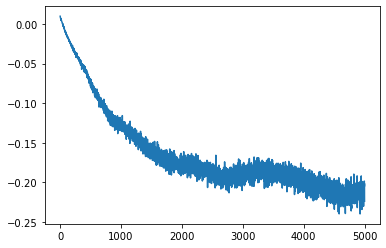

In [ ]:
plt.plot(losses);

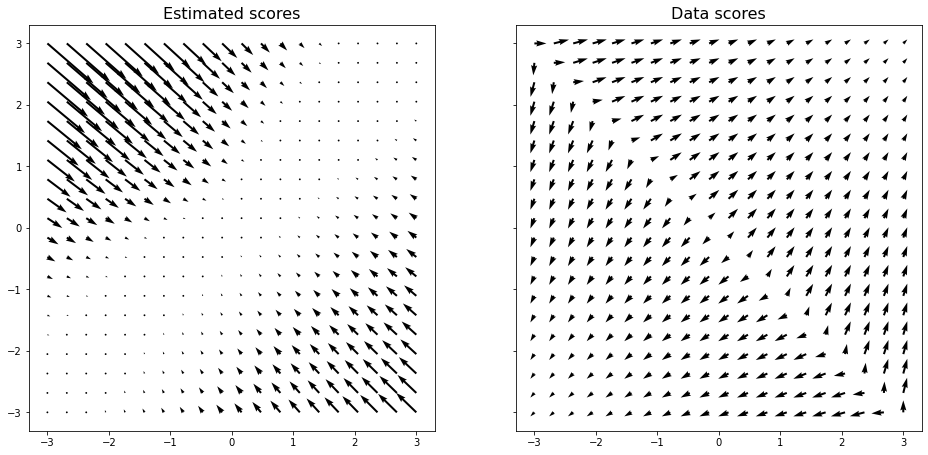

In [ ]:
plot_loss_quiever(model,teacher)

### Problem of score estimation

![Alt Text](  https://yang-song.net/assets/img/score/pitfalls.jpg)

## 2. Noise Conditional Score Network (NCSN) on toy Examples

Once we have trained a score-based model $S_{\theta}(x) = \nabla_{x} \log \mathbb{P}(x)$ we can use an iterative procedure called Langevin dynamics to draw samples from it.

Langevin dynamics provides an MCMC procedure to sample from a distribution $\mathbb{P}(x)$ using only its score function the score function. Specifically, it initializes the chain from an arbitrary prior distribution $x_{0} \sim \pi(x)$ and then iterates the following

$$x_{k+1} = x_{k} + \epsilon \nabla_{x} \log \mathbb{P}(x) + \sqrt{2\epsilon}z, \quad z \sim \mathcal{N}(z|0,I)$$

When $\epsilon \to 0$ as well as $K \to \infty$ , $x_{k}$ obtained from the procedure in Langevin Dynamics algorithm converges to a sample from $\mathbb{P}(x)$ under some regularity conditions. In practice, the error is negligible when $\epsilon$  is sufficiently small and $K$ is sufficiently large.

![Alt Text]( https://yang-song.net/assets/img/score/langevin.gif)

Next, we estimate the score function of each noise-perturbed distribution $\nabla \log \mathbb{P}{\sigma_{i}}(x)$, by training a Noise Conditional Score-Based Model $S(x_{i},\sigma_{i})$,with score matching, such that:

$$S(x_{i},\sigma_{i}) = \nabla_{x} \log \mathbb{P}_{\sigma}(x_{i})$$


![Alt Text](https://yang-song.net/assets/img/score/multi_scale.jpg)



The training objective for $S_{\theta}(x_{i},\sigma_{i})$ is a weighted sum of Fisher divergences for all noise scales. In particular, we use the objective below.

$$ \sum_{i=1}^{L} \lambda(i) \mathbb{E}_{\mathbb{P}_{\sigma_{i}}}||s_{\theta}(x,\sigma_{i}) - \nabla_{x} \log \mathbb{P}_{\sigma_{i}}(x)||_{2}^{2}$$

After training our noise-conditional score-based model $S_{\theta}(x,\sigma_{i})$, we can produce samples from it by running Langevin dynamics for $i = L,L-1,...,1$ in sequence. This method is called annealed Langevin dynamics since the noise scale $\sigma_{i}$ decreases (anneals) gradually over time.

 ![Alt Text]( https://yang-song.net/assets/img/score/ald.gif)



In [ ]:
def visualize(teacher, model, left_bound=-1., right_bound=1., savefig=None, step=None, device=None):

        #---------------------------------------------------#
        fig,ax = plt.subplots(2,3, figsize=(27,18),sharex=True, sharey=True,dpi=150 )

        mesh = []
        grid_size = 100
        x = np.linspace(left_bound, right_bound, grid_size)
        y = np.linspace(left_bound, right_bound, grid_size)
        for i in x:
            for j in y:
                mesh.append(np.asarray([i, j]))

        mesh = np.stack(mesh, axis=0)
        mesh = torch.from_numpy(mesh).float()
        if device is not None:
            mesh = mesh.to(device)

        logp_true = teacher.log_prob(mesh)
        logp_true = logp_true.view(grid_size, grid_size).exp()

        ax[0,0].grid(False)
        ax[0,0].axis('off')
        ax[0,0].set_title('Data density', fontsize=16)
        ax[0,0].imshow(np.flipud(logp_true.cpu().numpy()), cmap='inferno')



        #---------------------------------------------------------#

        grid_size = 20
        mesh = []
        x = np.linspace(left_bound, right_bound, grid_size)
        y = np.linspace(left_bound, right_bound, grid_size)
        for i in x:
            for j in y:
                mesh.append(np.asarray([i, j]))

        mesh = np.stack(mesh, axis=0)
        mesh = torch.from_numpy(mesh).float()
        if device is not None:
            mesh = mesh.to(device)


        scores = model(  mesh.detach().to(DEVICE) )
        mesh = mesh.detach().cpu().numpy()
        scores = scores.detach().cpu().numpy()

        ax[0,1].grid(False)
        ax[0,1].axis('off')
        ax[0,1].axis('square')
        ax[0,1].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
        ax[0,1].set_title('Estimated scores', fontsize=16)



        #-------------------------------------------------------------#

        samples = teacher.sample(1280)
        samples = samples.detach().cpu().numpy()
        ax[0,2].scatter(samples[:, 0], samples[:, 1], s=0.5)
        ax[0,2].axis('square')
        ax[0,2].set_title('data samples',fontsize=16)
        ax[0,2].set_xlim([left_bound, right_bound])
        ax[0,2].set_ylim([left_bound, right_bound])


        #------------------------------------------------------------#


        samples_ = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound

        samples = ncsn.langevin_dynamics(model, samples_).detach().numpy()
        ax[1,0].scatter(samples[:, 0], samples[:, 1], s=0.5)
        ax[1,0].axis('square')
        ax[1,0].axis('square')
        ax[1,0].set_title('Model Langevin dynamics',fontsize=16)
        ax[1,0].set_xlim([left_bound, right_bound])
        ax[1,0].set_ylim([left_bound, right_bound])


        #-----------------------------------------------------------#


        scores = data_score(torch.from_numpy(mesh) )
        scores = scores.detach().numpy()

        ax[1,1].axis('off')
        ax[1,1].quiver(mesh[:, 0], mesh[:, 1], scores[:, 0], scores[:, 1], width=0.005)
        ax[1,1].set_title('True Data scores', fontsize=16)
        ax[1,1].axis('square')



        samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound

        samples = ncsn.langevin_dynamics(data_score, samples).detach().numpy()
        ax[1,2].scatter(samples[:, 0], samples[:, 1], s=0.1)
        ax[1,2].axis('square')
        ax[1,2].set_title('True Langevin dynamics data',fontsize=16)
        ax[1,2].set_xlim([left_bound, right_bound])
        ax[1,2].set_ylim([left_bound, right_bound])


        """
        samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
        sigmas = torch.exp(torch.linspace(np.log(20), 0., 10)).to(DEVICE)
        labels = torch.linspace(1,10,10).to(DEVICE)
        samples = ncsn.anneal_langevin_dynamics(ncsn.score, samples.to(DEVICE), sigmas
                                             , labels).detach().cpu().numpy()

        plt.scatter(samples[:, 0], samples[:, 1], s=0.2)
        plt.axis('square')
        plt.title('Right Annealed Langevin dynamics samples')
        plt.xlim([left_bound, right_bound])
        plt.ylim([left_bound, right_bound])
        plt.show()
        """
        fig.tight_layout()
        plt.show()

In [ ]:
class NCSN(torch.nn.Module):

    def __init__(self, score, teacher, train_steps, lr, batch_size):
        super().__init__()
        self.train_steps = train_steps
        self.score = score
        self.teacher = teacher
        self.lr = lr
        self.batch_size = batch_size

    def langevin_dynamics(self, score, init, lr=0.1, step=1000):

        """
        score - torch.nn.Module
        init  - torch.Size([B,N])
        """
        for step in range(step):
            init = init + score(init)*lr + torch.randn_like(init,device=init.device)*np.sqrt(2*lr)
        return init

    def anneal_langevin_dynamics(self, score, init, sigmas, lr=0.1, n_steps_each=100):

        """
        score   - space-time torch.nn.Module
        init    - torch.Size([B,N])
        sigmas  - List
        """
        #with torch.no_grad
        for sigma in sigmas:
            current_lr = lr*sigma**2/sigmas[-1]**2
            for step in range(n_steps_each):
                init = init + 0.5*current_lr*score(init, sigma).detach()
                init = init + torch.randn_like(init, device=init.device)*np.sqrt(current_lr)

        return init

    def anneal_dsm_score_estimation(self,scorenet, samples, labels, sigmas, anneal_power=2.):

        batch_size = samples.shape[0]
        samples = samples.repeat(len(sigmas),1).reshape(len(sigmas),-1,samples.shape[-1])
        perturbed_samples = samples + torch.randn_like(samples)*sigmas.reshape(-1,1,1)

        scores = scorenet( perturbed_samples.reshape(-1,samples.shape[-1]),
                           labels.view(-1,1).expand( len(sigmas), batch_size).flatten().view(-1) )

        target = -1.*(perturbed_samples.reshape(-1,samples.shape[-1]) - samples.reshape(-1, samples.shape[-1]) )*\
                 (sigmas.view(-1,1).expand(len(sigmas),  batch_size).flatten().view(-1,1))**2

        loss = 1/2.*((scores - target)**2).sum(dim = -1)

        loss =  loss*\
              (sigmas.view(-1,1).expand(len(sigmas), batch_size).flatten().view(-1) )

        return loss.mean(dim=0)

    def train_(self, iterations = 10000, batch_size = 128):

        """
        hidden_units = 128
        score = torch.nn.Sequential(
            torch.nn.Linear(3, hidden_units),
            torch.nn.Softplus(),
            torch.nn.Linear(hidden_units, hidden_units),
            torch.nn.Softplus(),
            torch.nn.Linear(hidden_units, 2),
        )
        """
        losses = []
        optimizer = torch.optim.Adam(self.score.parameters(), lr=0.001)
        teacher = GMMDist(dim=2)

        for step in  tqdm(range(iterations)):
            samples = teacher.sample((batch_size,)).to(DEVICE)

            #loss, *_ = sliced_score_estimation_vr(score, samples, n_particles=1)

            loss = self.anneal_dsm_score_estimation(self.score, samples, labels = torch.linspace(1,10,10).to(DEVICE) ,
                                                    sigmas=torch.exp(torch.linspace(np.log(20), 0., 10)).to(DEVICE))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        return self.score, teacher, losses

    def train(self):
        opt_score = torch.optim.Adam(self.score.parameters(),lr=self.lr)
        for step in tqdm.tqdm(range(self.train_steps)):
            samples = self.teacher.sample(self.batch_size)
            opt_score.zero_grad()
            loss,*_ = sliced_score_estimation_vr(self.score, samples, n_particles = 1)
            loss.backward()
            opt_score.step()
        visualize(self.teacher, self.score, -8, 8)

In [ ]:
hidden_units = 128
model = torch.nn.Sequential(
    torch.nn.Linear(2, hidden_units),
    torch.nn.Softplus(),
    torch.nn.Linear(hidden_units, hidden_units),
    torch.nn.Softplus(),
    torch.nn.Linear(hidden_units, 2),
)
ncsn = NCSN(model, teachers[0], train_steps = 1000,lr=1e-3,batch_size=128)

In [ ]:
DEVICE="cpu"

100%|██████████| 1000/1000 [00:02<00:00, 482.13it/s]


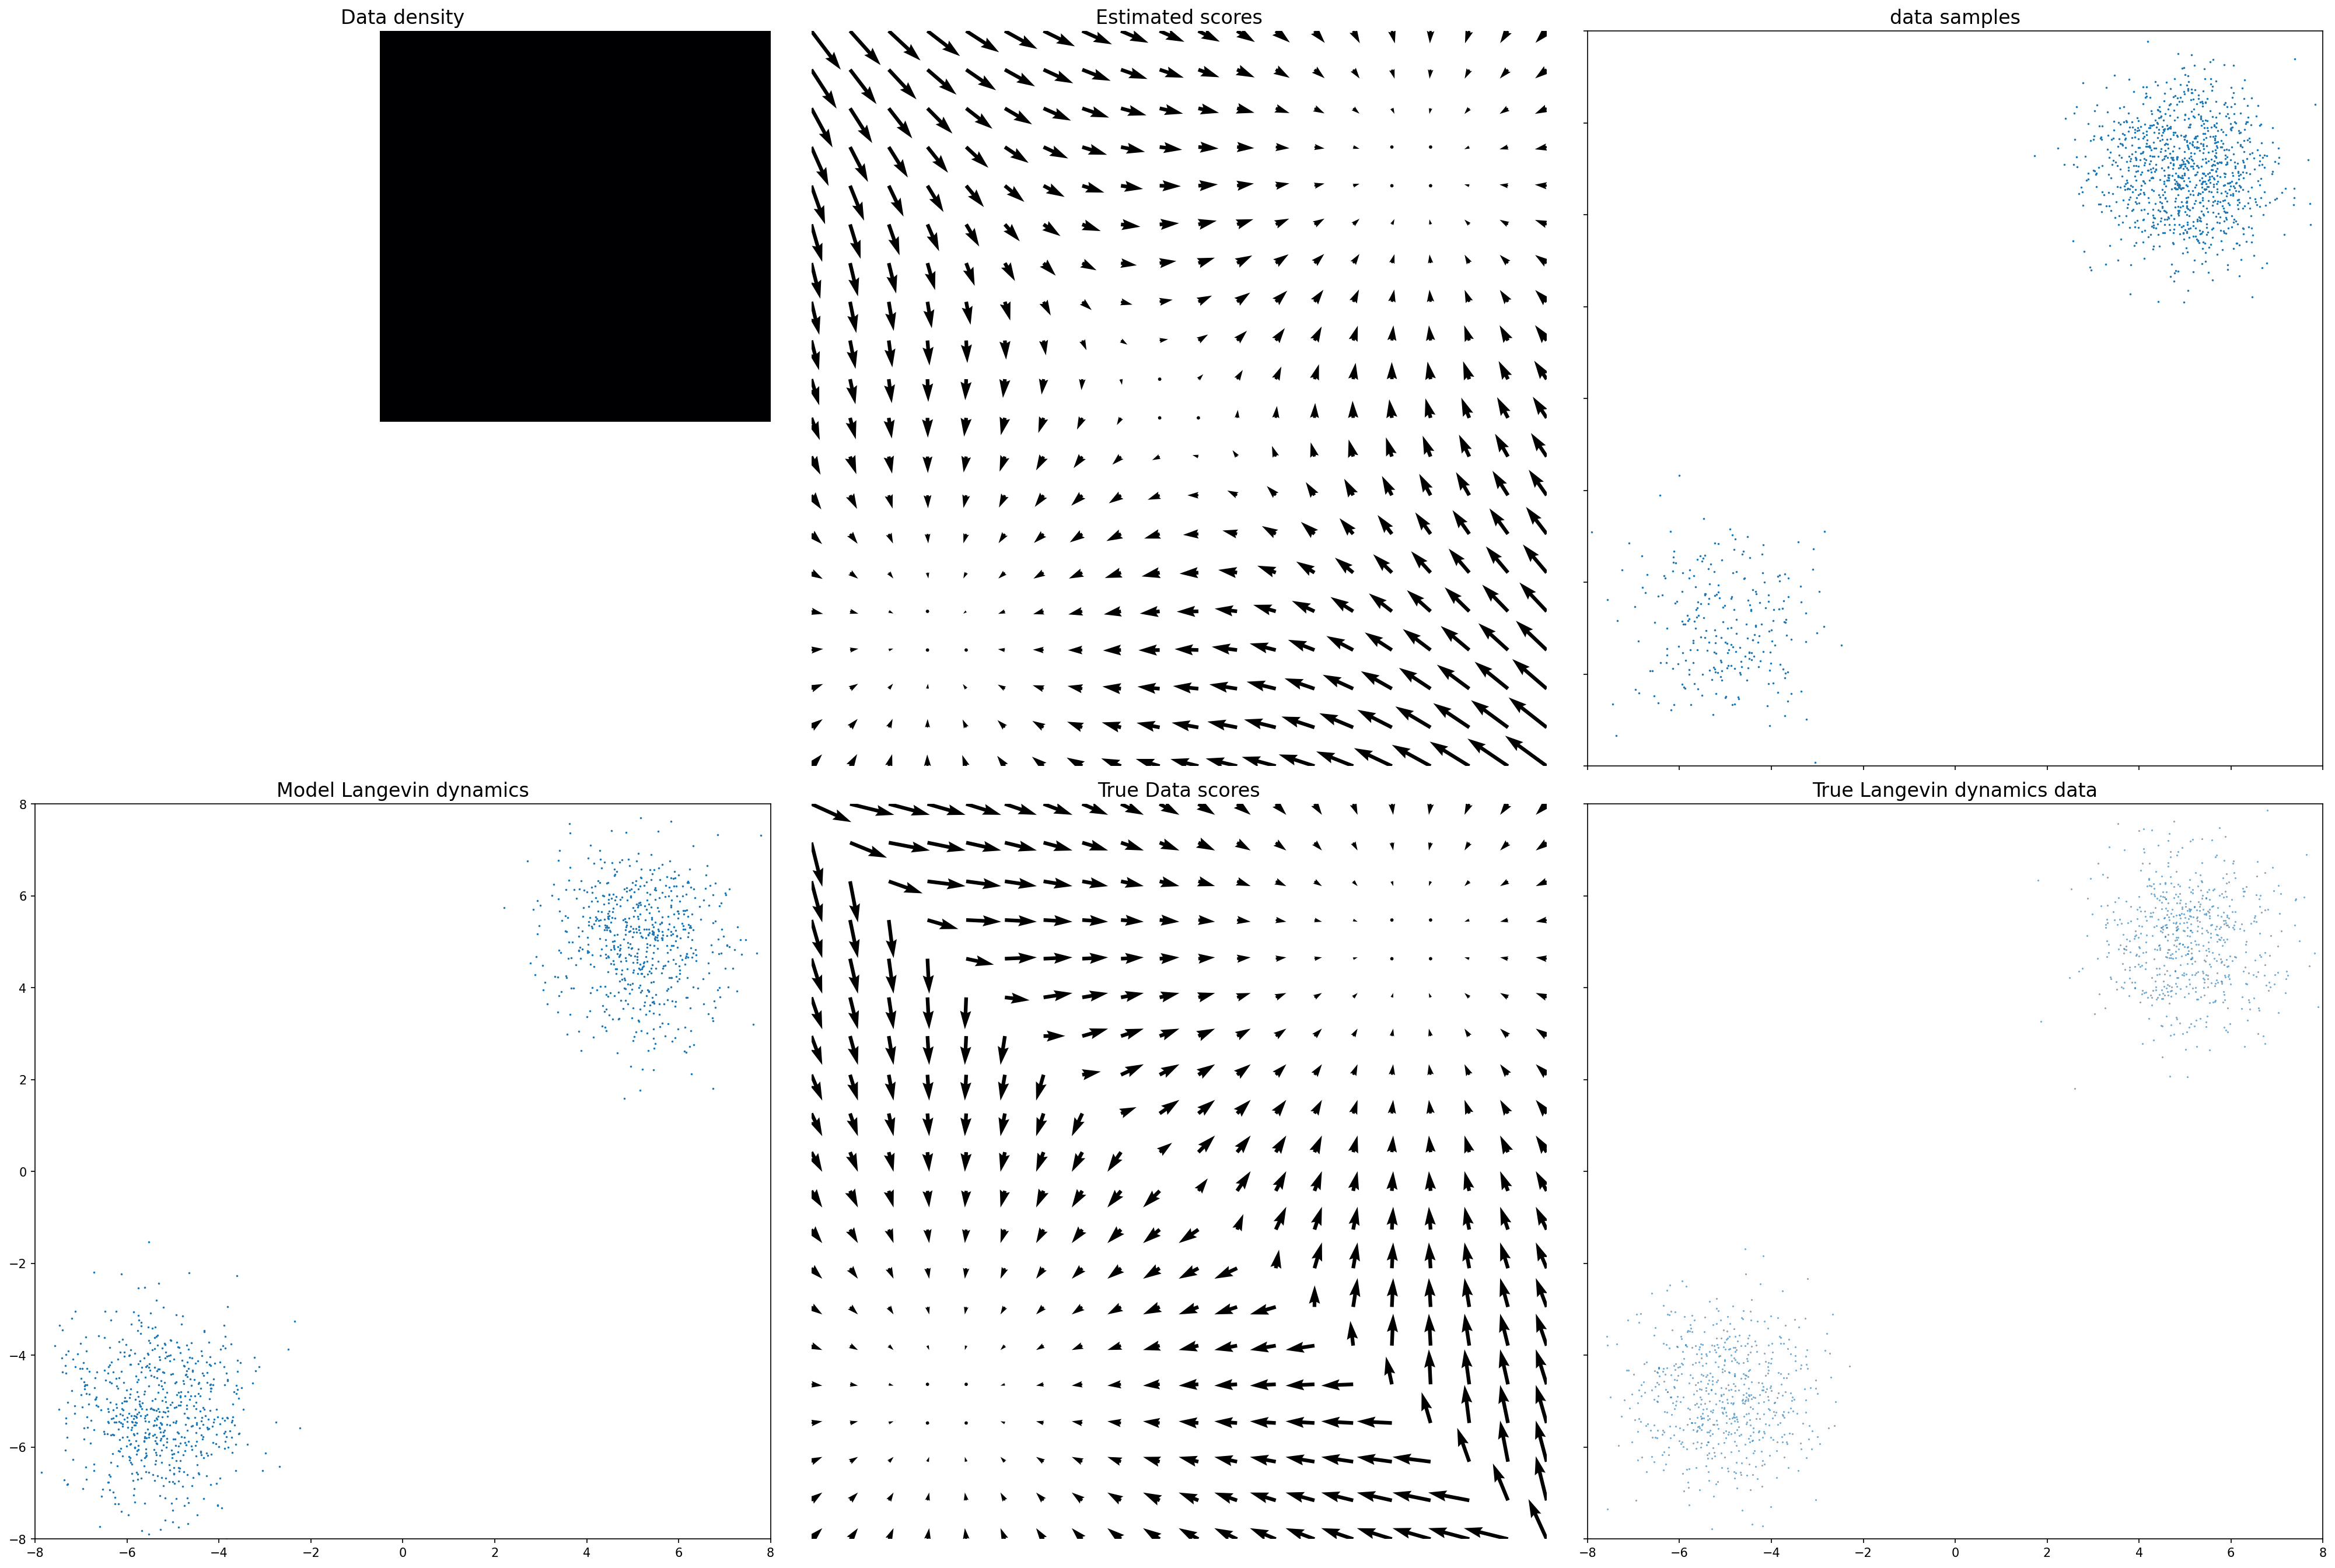

In [ ]:
ncsn.train()

 ![Alt Text]( https://c.tenor.com/Ez_CsXjGMmoAAAAd/mr-bean-mr-beans-holiday.gif)

## Questions